In [4]:
import cv2
import numpy as np
from tqdm import tqdm

###############################
# 1. 讀取影片所有影格
###############################
def extract_frames(video_path, extract_all=True, interval_seconds=0.1):
    """Extract frames from video with optional interval"""
    frames = []
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps * interval_seconds) if not extract_all else 1
    frame_count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Extracting frames from video: {video_path}")
    for _ in tqdm(range(total_frames), desc="Reading video frames"):
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frames.append(frame)
        frame_count += 1
    
    cap.release()
    print(f"Frames extracted: {len(frames)}")
    return frames

###############################
# 2. 深度偵測函式
###############################
def detect_objects_depth(depth_frame, prev_frame=None):
    """
    使用深度資訊 + (自訂)Sobel + Canny 來偵測前景物體
    回傳在深度畫面中偵測到的 bboxes (x1, y1, x2, y2 格式)
    """
    bboxes = []
    
    # 確保是單通道
    if len(depth_frame.shape) != 2:
        depth_frame = cv2.cvtColor(depth_frame, cv2.COLOR_BGR2GRAY)
    
    # 如果有前一張深度影格，則做差分
    if prev_frame is not None:
        if len(prev_frame.shape) != 2:
            prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        if prev_frame.shape != depth_frame.shape:
            prev_frame = cv2.resize(prev_frame, (depth_frame.shape[1], depth_frame.shape[0]))
    
    # 自適應二值化
    thresh = cv2.adaptiveThreshold(
        depth_frame,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        11,  # Block size (需為奇數)
        2    # 常數 (從均值中減去的值)
    )
    
    # Canny 邊緣
    canny_edges = enhance_edge_detection(depth_frame)

    # 如果有前一張影格，做差分再進一步 Sobel 閾值化
    if prev_frame is not None:
        frame_diff = cv2.absdiff(prev_frame, depth_frame)
        sobel_thresh = enhance_sobel_threshold(frame_diff)
    else:
        sobel_thresh = np.zeros_like(thresh)
    
    # 合併各種二值化結果
    combined_mask = cv2.bitwise_or(thresh, canny_edges)
    combined_mask = cv2.bitwise_or(combined_mask, sobel_thresh)
    
    # 找出外框
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 700:
            continue
        x, y, w, h = cv2.boundingRect(contour)
        bboxes.append((x, y, x + w, y + h))
    
    return bboxes

def enhance_edge_detection(frame):
    """加強 Canny 邊緣"""
    gray_frame = frame if len(frame.shape) == 2 else cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    canny_edges = cv2.Canny(gray_frame, 10, 30)
    return canny_edges

def enhance_sobel_threshold(frame_diff):
    """對差分影像做 Sobel + 自適應閾值，並做雙邊濾波去雜訊"""
    if len(frame_diff.shape) != 2:
        frame_diff = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
    
    filtered = cv2.bilateralFilter(frame_diff, 9, 75, 75)
    sobel_thresh = cv2.adaptiveThreshold(
        filtered,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        15,
        -0.5
    )
    
    kernel = np.ones((3,3), np.uint8)
    # 開、閉運算去雜訊
    sobel_thresh = cv2.morphologyEx(sobel_thresh, cv2.MORPH_OPEN, kernel)
    sobel_thresh = cv2.morphologyEx(sobel_thresh, cv2.MORPH_CLOSE, kernel)
    
    return sobel_thresh

###############################
# 3. 估計背景
###############################
def estimate_background_depth_only(rgb_video_path, depth_video_path):
    """
    只在深度影片下做差分偵測，RGB 影片純粹用來最後生成背景。
    """
    # 1. 讀取 RGB 與 Depth 所有影格
    rgb_frames = extract_frames(rgb_video_path)
    depth_frames = extract_frames(depth_video_path)
    
    # 若其中一方沒讀到，無法繼續
    if not rgb_frames or not depth_frames:
        print("Error: No frames extracted")
        return None
    
    # 先確保兩者 frame 數相同 (或至少取最小長度)
    min_len = min(len(rgb_frames), len(depth_frames))
    rgb_frames = rgb_frames[:min_len]
    depth_frames = depth_frames[:min_len]
    
    # 2. 初始化累計
    acc_frame = np.zeros_like(rgb_frames[0], dtype=np.float64)
    acc_weight = np.zeros_like(rgb_frames[0], dtype=np.float64)

    # 前一張深度
    prev_depth = None
    
    print("Processing frames (Depth-Only Detection) for background estimation...")
    for i in tqdm(range(min_len)):
        rgb_frame = rgb_frames[i]
        depth_frame = depth_frames[i]

        # 權重遮罩初始化為 1（代表背景區域）
        weight_mask = np.ones_like(rgb_frame, dtype=np.float64)

        # 深度差分偵測
        depth_boxes = detect_objects_depth(depth_frame, prev_depth)
        for (x1, y1, x2, y2) in depth_boxes:
            weight_mask[y1:y2, x1:x2] *= 0.001  # 降低前景區域的權重

        # 累積加權
        acc_frame += rgb_frame.astype(np.float64) * weight_mask
        acc_weight += weight_mask

        # 更新前一張深度
        prev_depth = depth_frame

    # 3. 最終背景 = 加權平均
    acc_weight[acc_weight == 0] = 1
    background = (acc_frame / acc_weight).astype(np.uint8)

    return background

###############################
# 主程式範例
###############################
if __name__ == "__main__":
    # 指定影片路徑 (一支彩色, 一支深度)
    rgb_video_path = r"E:\論文\期刊\code\final_video\aligned_tests_cropped_output_input.mp4"
    depth_video_path = r"E:\論文\期刊\code\final_video\aligned_tests_cropped_output_depth.mp4"

    # 只在深度影片下做偵測
    background = estimate_background_depth_only(rgb_video_path, depth_video_path)

    if background is not None:
        save_path = 'estimated_background_depthonly.jpg'
        cv2.imwrite(save_path, background)
        print("Background estimation completed and saved:", save_path)

        # 顯示結果
        cv2.imshow("Estimated Background (Depth-only Detection)", background)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


Extracting frames from video: E:\論文\期刊\code\final_video\aligned_tests_cropped_output_input.mp4


Reading video frames: 100%|██████████| 60/60 [00:00<00:00, 781.76it/s]


Frames extracted: 60
Extracting frames from video: E:\論文\期刊\code\final_video\aligned_tests_cropped_output_depth.mp4


Reading video frames: 100%|██████████| 60/60 [00:00<00:00, 842.48it/s]


Frames extracted: 60
Processing frames (Depth-Only Detection) for background estimation...


100%|██████████| 60/60 [00:01<00:00, 37.56it/s]


Background estimation completed and saved: estimated_background_depthonly.jpg


In [3]:
import cv2
import numpy as np
from tqdm import tqdm

###############################
# 1. 讀取影片所有影格
###############################
def extract_frames(video_path, extract_all=True, interval_seconds=0.1):
    """Extract frames from video with optional interval"""
    frames = []
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps * interval_seconds) if not extract_all else 1
    frame_count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Extracting frames from video: {video_path}")
    for _ in tqdm(range(total_frames), desc="Reading video frames"):
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frames.append(frame)
        frame_count += 1
    
    cap.release()
    print(f"Frames extracted: {len(frames)}")
    return frames

###############################
# 2. 深度偵測函式
###############################
def detect_objects_depth(depth_frame, prev_frame=None):
    """
    使用深度資訊 + Sobel + Canny 來偵測前景物體
    回傳:
      bboxes: [(x1, y1, x2, y2), ...]  # 偵測到的外框
      combined_mask: 合併後的二值化遮罩
    """
    bboxes = []
    
    # 確保深度影像是單通道
    if len(depth_frame.shape) != 2:
        depth_frame = cv2.cvtColor(depth_frame, cv2.COLOR_BGR2GRAY)
    
    # 若有上一幀，則做前後影格差分
    if prev_frame is not None:
        if len(prev_frame.shape) != 2:
            prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        if prev_frame.shape != depth_frame.shape:
            prev_frame = cv2.resize(prev_frame, (depth_frame.shape[1], depth_frame.shape[0]))

    # 自適應二值化
    thresh = cv2.adaptiveThreshold(
        depth_frame,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        11,  # Block size (需為奇數)
        2    # 常數 (從均值中減去的值)
    )

    # Canny 邊緣
    canny_edges = cv2.Canny(depth_frame, 10, 30)

    # Sobel (用在前後幀差分)
    if prev_frame is not None:
        frame_diff = cv2.absdiff(prev_frame, depth_frame)
        sobel_thresh = enhance_sobel_threshold(frame_diff)
    else:
        sobel_thresh = np.zeros_like(thresh)

    # 合併各種二值化結果
    combined_mask = cv2.bitwise_or(thresh, canny_edges)
    combined_mask = cv2.bitwise_or(combined_mask, sobel_thresh)

    # 找出外框
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 700:
            continue
        x, y, w, h = cv2.boundingRect(contour)
        bboxes.append((x, y, x + w, y + h))
    
    return bboxes, combined_mask

def enhance_sobel_threshold(frame_diff):
    """對差分影像做 Sobel + 自適應閾值，並做雙邊濾波去雜訊"""
    if len(frame_diff.shape) != 2:
        frame_diff = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
    
    filtered = cv2.bilateralFilter(frame_diff, 9, 75, 75)
    sobel_thresh = cv2.adaptiveThreshold(
        filtered,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        15,
        -0.5
    )
    
    # 對結果做形態學運算去雜
    kernel = np.ones((3,3), np.uint8)
    sobel_thresh = cv2.morphologyEx(sobel_thresh, cv2.MORPH_OPEN, kernel)
    sobel_thresh = cv2.morphologyEx(sobel_thresh, cv2.MORPH_CLOSE, kernel)
    
    return sobel_thresh

###############################
# 3. 估計背景 + 顯示預選框與最後遮罩
###############################
def estimate_background_depth_only(rgb_video_path, depth_video_path, debug=False):
    """
    只在深度影片下做差分偵測，RGB 影片純粹用於最後生成背景。
    若 debug=True，則會顯示含預選框的影像，以及最後合併後的遮罩。
    """
    # 1. 讀取 RGB 與 Depth 所有影格
    rgb_frames = extract_frames(rgb_video_path)
    depth_frames = extract_frames(depth_video_path)
    
    # 若其中一方沒讀到，無法繼續
    if not rgb_frames or not depth_frames:
        print("Error: No frames extracted")
        return None
    
    # 先確保兩者 frame 數相同 (或至少取最小長度)
    min_len = min(len(rgb_frames), len(depth_frames))
    rgb_frames = rgb_frames[:min_len]
    depth_frames = depth_frames[:min_len]
    
    # 2. 初始化累計
    acc_frame = np.zeros_like(rgb_frames[0], dtype=np.float64)
    acc_weight = np.zeros_like(rgb_frames[0], dtype=np.float64)

    # 前一張深度影格
    prev_depth = None
    
    print("Processing frames (Depth-Only Detection) for background estimation...")
    for i in tqdm(range(min_len)):
        rgb_frame = rgb_frames[i]
        depth_frame = depth_frames[i]

        # 用深度偵測前景
        bboxes, combined_mask = detect_objects_depth(depth_frame, prev_depth)

        # 建立權重遮罩 (全部初始化為1，表示預設視為背景)
        weight_mask = np.ones_like(rgb_frame, dtype=np.float64)

        # 偵測到的前景區域在權重上減少
        for (x1, y1, x2, y2) in bboxes:
            weight_mask[y1:y2, x1:x2] *= 0.001

        # 累積加權
        acc_frame += rgb_frame.astype(np.float64) * weight_mask
        acc_weight += weight_mask

        # 顯示偵測到的外框 + 合併遮罩
        if debug:
            # 在 RGB 畫面上畫出前景框
            debug_rgb = rgb_frame.copy()
            for (x1, y1, x2, y2) in bboxes:
                cv2.rectangle(debug_rgb, (x1, y1), (x2, y2), (0, 0, 255), 2)

            # 顯示原影像的前景框
            cv2.imshow("Detected Frame", debug_rgb)
            # 顯示最後的合併遮罩
            cv2.imshow("Final Mask", combined_mask)

            key = cv2.waitKey(1)
            if key == 27:  # ESC 鍵
                print("Early stop by user.")
                break
        
        # 更新前一張深度影格
        prev_depth = depth_frame

    if debug:
        cv2.destroyAllWindows()

    # 3. 最終背景 = 加權平均
    acc_weight[acc_weight == 0] = 1
    background = (acc_frame / acc_weight).astype(np.uint8)

    return background

###############################
# 主程式範例
###############################
if __name__ == "__main__":
    # 指定影片路徑 (一支彩色, 一支深度)
    rgb_video_path = r"E:\論文\期刊\code\final_video\aligned_tests_cropped_output_input.mp4"
    depth_video_path = r"E:\論文\期刊\code\final_video\aligned_tests_cropped_output_depth.mp4"

    # debug=True：將顯示預選框與最後的遮罩
    background = estimate_background_depth_only(rgb_video_path, depth_video_path, debug=True)

    # 若有產出背景，即保存並顯示
    if background is not None:
        save_path = 'estimated_background_depthonly.jpg'
        cv2.imwrite(save_path, background)
        print("Background estimation completed and saved:", save_path)

        cv2.imshow("Estimated Background (Depth-only Detection)", background)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


Extracting frames from video: E:\論文\期刊\code\final_video\aligned_tests_cropped_output_input.mp4


Reading video frames: 100%|██████████| 60/60 [00:00<00:00, 696.19it/s]


Frames extracted: 60
Extracting frames from video: E:\論文\期刊\code\final_video\aligned_tests_cropped_output_depth.mp4


Reading video frames: 100%|██████████| 60/60 [00:00<00:00, 764.32it/s]


Frames extracted: 60
Processing frames (Depth-Only Detection) for background estimation...


100%|██████████| 60/60 [00:05<00:00, 11.70it/s]


Background estimation completed and saved: estimated_background_depthonly.jpg


## MAIN

[(38, 551, 34, 25), (126, 550, 29, 26), (76, 528, 28, 48), (152, 522, 74, 54), (178, 521, 56, 54), (80, 483, 79, 66), (504, 480, 31, 73), (463, 461, 29, 76), (0, 452, 153, 80), (504, 312, 30, 89), (452, 310, 31, 81), (450, 138, 29, 73), (499, 127, 36, 120), (928, 101, 82, 63), (782, 72, 34, 67), (237, 64, 43, 51), (306, 52, 35, 19), (293, 14, 54, 42), (452, 0, 30, 66)]


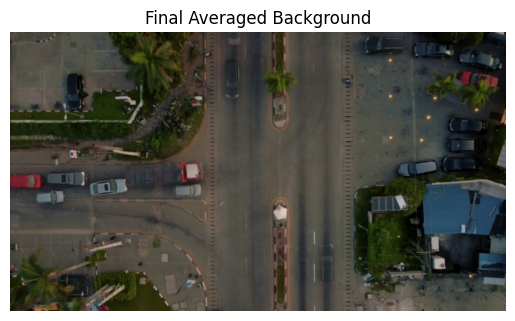

In [5]:
import cv2
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
def difference_based_object_detection(video_path, frame_gap, overlap_threshold=0.5):
    ## Sobel 算子計算梯度
    def image_process(img):
        """
        使用 Sobel 算子計算梯度
        """
        dstx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
        dsty = cv2.Sobel(img, cv2.CV_32F, 0, 1)
        dstx = cv2.convertScaleAbs(dstx)
        dsty = cv2.convertScaleAbs(dsty)
        dst = cv2.addWeighted(dstx, 0.5, dsty, 0.5, 0)
        return dst
    ## canny 邊緣檢測生成候選框
    def generate_candidate_boxes(edge_img):
        """
        根據邊緣圖生成候選框
        """
        contours, _ = cv2.findContours(edge_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        boxes = []
        for contour in contours:
            if cv2.contourArea(contour) < 5:
                continue
            x, y, w, h = cv2.boundingRect(contour)
            boxes.append((x, y, w, h))
        return boxes
    ## 計算兩個框的重疊區域佔比（IOU）
    def calculate_overlap_ratio(box1, box2):
        """
        計算兩個框的重疊區域佔比（IOU）
        """
        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2

        # 計算交集
        inter_x1 = max(x1, x2)
        inter_y1 = max(y1, y2)
        inter_x2 = min(x1 + w1, x2 + w2)
        inter_y2 = min(y1 + h1, y2 + h2)

        # 沒有交集
        if inter_x1 >= inter_x2 or inter_y1 >= inter_y2:
            return 0.0

        # 計算交集面積
        intersection_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)

        # 計算聯合區域面積
        box1_area = w1 * h1
        box2_area = w2 * h2
        union_area = box1_area + box2_area - intersection_area

        # 返回重疊比例（IOU）
        return intersection_area / union_area

    cap = cv2.VideoCapture(video_path)
    frames_buffer = deque(maxlen=frame_gap)

    # 初始化緩衝區
    for _ in range(frame_gap):
        ret, frame = cap.read()
        if not ret:
            print("無法讀取視頻")
            return
        processed_frame = image_process(frame)
        frames_buffer.append(processed_frame)
    total_final_boxes = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Sobel 差分處理
        processed_frame = image_process(frame)
        prev_frame = frames_buffer[-frame_gap]
        frame_diff = cv2.absdiff(prev_frame, processed_frame)

        # 確保 frame_diff 是灰階且為 uint8
        if len(frame_diff.shape) != 2:
            frame_diff = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
        frame_diff = np.clip(frame_diff, 0, 255).astype(np.uint8)

        # 二值化處理
        _, sobel_thresh = cv2.threshold(frame_diff, 5, 255, cv2.THRESH_BINARY)

        # Sobel 框生成
        sobel_contours, _ = cv2.findContours(sobel_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        sobel_boxes = [cv2.boundingRect(contour) for contour in sobel_contours if cv2.contourArea(contour) >= 100]

        # Canny 邊緣檢測
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        canny_edges = cv2.Canny(gray_frame, 10, 30)
        canny_boxes = generate_candidate_boxes(canny_edges)

        # 比較重疊框，根據重疊閥值篩選
        final_boxes = []
        for canny_box in canny_boxes:
            for sobel_box in sobel_boxes:
                overlap_ratio = calculate_overlap_ratio(canny_box, sobel_box)
                if overlap_ratio >= overlap_threshold:  # 如果重疊比例超過閥值
                    final_boxes.append(canny_box)
                    break

        # 繪製候選框
        combined_frame = frame.copy()
        final_frame = frame.copy()

        # 繪製 Canny 框（紅色）
        for x, y, w, h in sobel_boxes:
            cv2.rectangle(combined_frame, (x, y), (x + w, y + h), (255, 0, 0), 2)  # 紅色框

        # 繪製 Canny 框（紅色）
        for x, y, w, h in canny_boxes:
            cv2.rectangle(combined_frame, (x, y), (x + w, y + h), (0, 0, 255), 2)  # 紅色框

        # 繪製最終框（綠色）
        for x, y, w, h in final_boxes:
            cv2.rectangle(final_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)  # 綠色框
        total_final_boxes.append(final_boxes)
        # 顯示 Canny 邊緣圖和 Sobel 差分圖
        cv2.imshow("Canny Edges", canny_edges)
        cv2.imshow("Sobel Difference", sobel_thresh)

        # 顯示綜合檢測結果
        cv2.imshow("Combined Detection (Sobel & Canny)", combined_frame)
        cv2.imshow("Final Detected Objects (Green Only)", final_frame)

        frames_buffer.append(processed_frame)

        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    return total_final_boxes

def average_background_final_plot(video_path, total_final_boxes):
    """
    從頭到尾讀完整部影片，只在結束後計算整體平均背景，並用 plt 顯示最終結果。
    total_final_boxes[i] = [ (x1, y1, w1, h1), (x2, y2, w2, h2), ... ]
    表示第 i 張影格上的多個 bounding boxes。
    """

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("無法讀取影片")
        return

    # 用來累加所有影格加總
    acc_frame = None
    # 用來累加所有影格的權重
    acc_weight = None

    frame_index = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # 影片結束或讀取失敗

        # 初始化 acc_frame, acc_weight（只在第一次用到frame的大小時設定）
        if acc_frame is None:
            acc_frame = np.zeros_like(frame, dtype=np.float64)
            acc_weight = np.zeros_like(frame, dtype=np.float64)

        # 建立權重遮罩，全1
        weight_mask = np.ones(frame.shape[:2], dtype=np.float64)

        # 若在 total_final_boxes 中有針對第 frame_index 幀的 bounding boxes
        # 就將對應區域的權重降為 0.01
        if frame_index < len(total_final_boxes):
            for (x, y, w, h) in total_final_boxes[frame_index]:
                x_end = min(x + w, frame.shape[1])
                y_end = min(y + h, frame.shape[0])
                weight_mask[y:y_end, x:x_end] = 0.01

        # 升維，讓 weight_mask 跟 (H, W, 3) 做運算
        weight_mask_3d = weight_mask[..., None]

        # 累加：frame * mask
        current_frame_float = frame.astype(np.float64)
        acc_frame  += current_frame_float * weight_mask_3d
        acc_weight += weight_mask_3d

        frame_index += 1

    # 所有影格讀完後，計算最終平均背景
    background_float = acc_frame / np.clip(acc_weight, 1e-8, None)
    background_uint8 = background_float.astype(np.uint8)

    cap.release()

    # OpenCV 默認是 BGR，但 matplotlib 的 imshow 預設是 RGB，所以需要轉色
    background_rgb = cv2.cvtColor(background_uint8, cv2.COLOR_BGR2RGB)

    # 用 plt 顯示最終結果
    plt.imshow(background_rgb)
    plt.title("Final Averaged Background")
    plt.axis('off')  # 隱藏軸
    plt.show()
if __name__ == "__main__":
    rgb_video_path = r"E:\論文\期刊\code\final_video\aligned_tests_cropped_output_input.mp4"
    depth_video_path = r"E:\論文\期刊\code\final_video\aligned_tests_cropped_output_depth.mp4"
    final_boxes=difference_based_object_detection(depth_video_path, frame_gap=1, overlap_threshold=0.3)
    print(final_boxes[0])
    average_background_final_plot(rgb_video_path,final_boxes)